## 4차 과제 - Hyperparameter Tuning을 해보자
- 주제: 하이퍼파라미터 튜닝 기법 학습
- 데이터: The History of Baseball(Pitching Data) https://www.kaggle.com/datasets/seanlahman/the-history-of-baseball?select=pitching.csv
- 사용 라이브러리: pandas, numpy, matplotlib, sklearn, imblearn, bayes_opt

### 1. EDA, 전처리

1.1 분석을 위해 사용될 라이브러리들을 import 하세요.

numpy, pandas, matplotlib, SMOTE, train_test_split, RandomForestClassifier, RandomizedSearchCV, GridSearchCV, BayesianOptimization, accuracy_score

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score
from bayes_opt import BayesianOptimization
from hyperopt import hp, tpe, Trials, fmin
from xgboost import XGBClassifier, plot_importance

1.2 데이터를 불러오고 info()를 통해 데이터를 살펴보세요.

In [5]:
pitching = pd.read_csv('./pitching.csv')
pitching

,player_id,year,stint,team_id,league_id,w,l,g,gs,cg,...,ibb,wp,hbp,bk,bfp,gf,r,sh,sf,g_idp
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,...,NaN,NaN,NaN,0,NaN,NaN,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,...,NaN,NaN,NaN,0,NaN,NaN,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,...,NaN,NaN,NaN,0,NaN,NaN,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,...,NaN,NaN,NaN,0,NaN,NaN,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,...,NaN,NaN,NaN,0,NaN,NaN,21,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44134,youngch03,2015,1,KCA,AL,11,6,34,18,0,...,0.0,5.0,0.0,0,500.0,3.0,44,4.0,2.0,NaN
44135,zieglbr01,2015,1,ARI,NL,0,3,66,0,0,...,3.0,2.0,1.0,0,263.0,46.0,17,1.0,0.0,NaN
44136,zimmejo02,2015,1,WAS,NL,13,10,33,33,0,...,3.0,2.0,8.0,1,831.0,0.0,89,8.0,2.0,NaN
44137,zitoba01,2015,1,OAK,AL,0,0,3,2,0,...,0.0,0.0,0.0,0,37.0,1.0,8,0.0,0.0,NaN


1.3 null 값이 있는 컬럼은 모두 삭제하겠습니다(원래는 다른 처리를 해야 하지만 컬럼 수는 충분하니까..ㅎㅎ 야구 잘 몰라서 그런 거 아닙니다.).

In [9]:
# 결측치가 있는 컬럼 확인

pd.isna(pitching).sum()

player_id    0
year         0
stint        0
team_id      0
w            0
l            0
g            0
gs           0
cg           0
sho          0
sv           0
h            0
er           0
hr           0
bb           0
so           0
bk           0
r            0
dtype: int64

In [10]:
# 결측치가 있는 컬럼 제거

pitching.dropna(axis = 1, inplace = True)
pitching

,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,bechtge01,1871,1,PH1,1,2,3,3,2,0,0,43,23,0,11,1,0,42
1,brainas01,1871,1,WS3,12,15,30,30,30,0,0,361,132,4,37,13,0,292
2,fergubo01,1871,1,NY2,0,0,1,0,0,0,0,8,3,0,0,0,0,9
3,fishech01,1871,1,RC1,4,16,24,24,22,1,0,295,103,3,31,15,0,257
4,fleetfr01,1871,1,NY2,0,1,1,1,1,0,0,20,10,0,3,0,0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44134,youngch03,2015,1,KCA,11,6,34,18,0,0,0,91,42,16,43,83,0,44
44135,zieglbr01,2015,1,ARI,0,3,66,0,0,0,30,48,14,3,17,36,0,17
44136,zimmejo02,2015,1,WAS,13,10,33,33,0,0,0,204,82,24,39,164,1,89
44137,zitoba01,2015,1,OAK,0,0,3,2,0,0,0,12,8,4,6,2,0,8


1.4 연도 별로 몇개의 데이터가 있는 지 확인 후 데이터가 얼마 없는 과거 데이터는 삭제하겠습니다. 이를 위해 연도 별 데이터 수를 계산하고 line plot으로 그리세요.

In [8]:
year = pitching['year'].value_counts().sort_index()
year

1871     19
1872     23
1873     25
1874     17
1875     47
       ... 
2011    707
2012    722
2013    726
2014    746
2015    809
Name: year, Length: 145, dtype: int64

<Axes: >

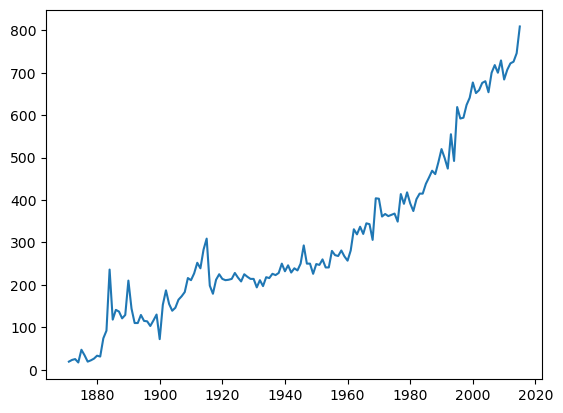

In [11]:
sns.lineplot(x = year.index, y = year.values)

1.5 보다 최신 분석을 위해 1980년 이후의 데이터만 남기고 몇개의 데이터가 남았는지 확인하세요.

In [12]:
pitching = pitching.query('year >= 1980')
pitching['year'].value_counts().sort_index()

1980    392
1981    374
1982    402
1983    415
1984    415
1985    438
1986    453
1987    469
1988    461
1989    489
1990    520
1991    499
1992    474
1993    555
1994    492
1995    619
1996    592
1997    594
1998    624
1999    641
2000    677
2001    652
2002    659
2003    676
2004    680
2005    654
2006    700
2007    718
2008    700
2009    729
2010    684
2011    707
2012    722
2013    726
2014    746
2015    809
Name: year, dtype: int64

1.6 reset_index()를 통해 재배열하세요.

In [13]:
pitching.reset_index(drop = True)

,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,aasedo01,1980,1,CAL,8,13,40,21,5,1,2,193,79,13,66,74,1,83
1,abbotgl01,1980,1,SEA,12,12,31,31,7,2,0,228,98,27,49,78,1,110
2,alexado01,1980,1,ATL,14,11,35,35,7,1,0,227,108,20,74,114,0,120
3,allarbr01,1980,1,TEX,0,1,5,2,0,0,0,13,9,0,10,10,0,13
4,allenne01,1980,1,NYN,7,10,59,0,0,0,22,87,40,7,40,79,1,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21152,youngch03,2015,1,KCA,11,6,34,18,0,0,0,91,42,16,43,83,0,44
21153,zieglbr01,2015,1,ARI,0,3,66,0,0,0,30,48,14,3,17,36,0,17
21154,zimmejo02,2015,1,WAS,13,10,33,33,0,0,0,204,82,24,39,164,1,89
21155,zitoba01,2015,1,OAK,0,0,3,2,0,0,0,12,8,4,6,2,0,8


1.7 투수의 승리 수를 예측해보겠습니다. w 컬럼의 value를 확인해보세요.

In [14]:
pitching['w'].value_counts().sort_index()

0     5854
1     3197
2     2356
3     1744
4     1453
5     1114
6      878
7      730
8      557
9      560
10     450
11     434
12     384
13     317
14     287
15     242
16     193
17     125
18     102
19      61
20      53
21      32
22      17
23       7
24       8
25       1
27       1
Name: w, dtype: int64

1.8 0승 투수(출전하지 않은 경우도 존재)가 많으므로 승리 수가 0인 데이터는 삭제하겠습니다.

In [15]:
pitching = pitching.query('w > 0')
pitching['w'].value_counts().sort_index()

1     3197
2     2356
3     1744
4     1453
5     1114
6      878
7      730
8      557
9      560
10     450
11     434
12     384
13     317
14     287
15     242
16     193
17     125
18     102
19      61
20      53
21      32
22      17
23       7
24       8
25       1
27       1
Name: w, dtype: int64

1.9 Regression이 아닌 Classification으로 분석해보겠습니다. 이를 위해 10을 기준으로 w를 10승 이상이면 1, 10승 미만이면 0인 Binary 형태로 변환하세요.

In [16]:
pitching['w'] = (pitching['w'] >= 10).astype(int)

1.10 value_counts()를 통해 잘 나눠졌는지 확인해보세요.

In [17]:
pitching['w'].value_counts().sort_index()

0    12589
1     2714
Name: w, dtype: int64

1.11 종속 변수의 밸런스가 맞지 않는 것으로 확인됩니다. 이를 해결하기 위해 Under Sampling 혹은 Over Sampling 기법을 사용할 수 있는데 Under Sampling의 경우 데이터가 많지 않는 상황에서 사라지는 데이터가 과도하게 많으므로 Over Sampling 기법 중 SMOTE 기법을 사용해보겠습니다. 사용하기 전에 player_id, year, team_id 컬럼은 지우고 가겠습니다.

In [18]:
pitching.drop(columns = ['player_id', 'year', 'team_id'], inplace = True)
pitching

,stint,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
22982,1,0,13,40,21,5,1,2,193,79,13,66,74,1,83
22983,1,1,12,31,31,7,2,0,228,98,27,49,78,1,110
22984,1,1,11,35,35,7,1,0,227,108,20,74,114,0,120
22986,1,0,10,59,0,0,0,22,87,40,7,40,79,1,43
22988,1,0,8,35,14,0,0,2,132,53,8,43,75,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44129,1,0,5,12,9,0,0,0,52,30,9,18,26,0,30
44130,1,0,4,16,9,0,0,0,67,33,12,27,52,0,38
44133,1,0,0,20,0,0,0,0,23,18,10,7,21,0,18
44134,1,1,6,34,18,0,0,0,91,42,16,43,83,0,44


1.12 SMOTE 기법을 활용해 w의 balance를 맞추세요(sampling_strategy='auto', random_state = 123).

In [19]:
smote = SMOTE(sampling_strategy = 'auto', random_state = 123)
X = pitching.drop(columns = 'w')
y = pitching['w']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [61]:
#전체 학습 샘플 데이터의 양이 증가하면서 0/1 클래스의 분포가 동일해짐

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (11477, 14) (11477,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (18974, 14) (18974,)
SMOTE 적용 후 레이블 값 분포: 
 0    9487
1    9487
Name: w, dtype: int64


1.14 SMOTE의 동작 방식에 대해 작성하고 Over Sampling의 장/단점에 대해 작성하세요.

A: SMOTE는 데이터의 개수가 적은 클래스의 표본을 가져온 뒤 임의의 값을 추가하여 새로운 샘플을 만들어 데이터에 추가하는 Over Sampling 방식입니다. Ove Sampling은 전체 데이터 제거로 학습 시간을 줄일 수 있다는 장점이 있으나, 데이터 제거로 인한 정보의 손실이 발생한다는 단점이 있습니다.

1.15 다른 Over Sampling 기법들엔 어떤 것들이 있는지 작성하세요(2개 이상).

1. Resampling: 소수 클래스의 데이터를 그대로 복제하여 데이터 수를 늘리는 기법
2. Borderline-SMOTE: 다수 클래스와 가까운 경계에 존재하는 소수 클래스만 선택하여 SMOTE를 진행하는 기법
3. ADASYN(Adaptive Synthetic Sampling Approach): 다수 클래스와의 거리에 따라 Over Sampling하는 데이터의 개수를 다르게 하는 기법

### 2. 예측 및 분석

2.1 본격적으로 분석을 진행하겠습니다. 본 차시는 Hyperparameter Tuning에 대해 학습하는 것이 목적이므로 모델은 RandomForest Classifier 하나만 사용하도록 하겠습니다. 먼저 데이터를 train, validation, test 3개로 나누세요(train-60%, val-20%, test-20%).

In [33]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_train_over, y_train_over,
                                                  test_size = 0.2, random_state = 123)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                 test_size = 0.25, random_state = 123)

print('train set: ', X_train.shape)
print('validation set: ', X_val.shape)
print('test set: ', X_test.shape)

train set:  (11384, 14)
validation set:  (3795, 14)
test set:  (3795, 14)


2.2 train test에 validation set을 추가하는 이유가 뭔지 작성하세요.

A: test set에 라벨이 없는 경우가 있는데 이럴 때 train set을 validation set으로 분리해서 최대한 랜덤하게 샘플링된 성능 평가를 위한 데이터 셋으로 활용할 수 있다. 또한 test set은 모델의 성능을 튜닝하는 데에 사용하면 안 되므로 validation set을 추가하여 사용한다.

2.3 Randomized SearchCV로 최적의 파라미터 셋을 찾으세요(성능 지표는 accuracy score).

In [63]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

randomforest = RandomForestClassifier(random_state = 123)
randomsearch = RandomizedSearchCV(estimator = randomforest, param_distributions = param_grid,
                                 scoring = 'accuracy', random_state = 123)

randomsearch.fit(X_train, y_train)
print('최적의 하이퍼 파라미터 셋: ', randomsearch.best_params_)

최적의 하이퍼 파라미터 셋:  {'n_estimators': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}


2.4 위에서 지정한 hyperparameter들이 각각 무엇을 의미하는지 작성하세요.

1. n_estimators: 랜덤 포레스트를 구성할 결정 트리 개수, 기본값: 100
2. min_samples_split: 노드 분할을 위한 최소 데이터 개수
3. min_samples_leaf: 말단 노드가 되기 위한 최소 데이터 개수
4. max_depth: 트리의 최대 깊이
5. criterion: 분할 시 사용할 불순도 측정 지표
6. booststrap: 각 트리를 구성할 때 데이터의 샘플링 방법 결정

2.5 Grid SearchCV로 최적의 파라미터 셋을 찾으세요.

In [86]:
randomforest = RandomForestClassifier(random_state = 123)
gridsearch = GridSearchCV(estimator = randomforest, param_grid = param_grid,
                                 scoring = 'accuracy', cv = 5)

gridsearch.fit(X_train, y_train)
print('최적의 하이퍼 파라미터 셋: ', gridsearch.best_params_)

최적의 하이퍼 파라미터 셋:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


2.6 Randomized SearchCV와 Grid SearchCV의 차이와 장단점에 대해 설명하세요.

<figure>
    <img src="https://miro.medium.com/v2/resize:fit:781/1*8uSZqUSGa-UGF-0CDBd4Jw.png">
</figure>

A: Randomized SearchCV는 검증하려는 하이퍼 파라미터들의 값 범위를 지정해주면 무작위로 값을 지정해 그 조합을 모두 검증하는 것이고, Grid SearchCV는 검증하고 싶은 하이퍼 파라미터들의 수치를 정해주고 그 조합을 모두 검증하는 것이다.

1. Randomized SearchCV는 계산 비용과 시간을 크게 절약할 수 있다는 장점이 있으나, 최적의 조합을 놓칠 수 있다는 단점이 있다.
2. Grid SearchCV는 최적의 조합을 확실하게 찾을 수 있다는 장점이 있으나, 계산 비용과 시간이 많이 든다는 단점이 있다.

2.7 이번엔 Bayesian Optimization을 사용해 파라미터 튜닝을 진행해보겠습니다.

In [99]:
space = {
    'n_estimators': hp.choice('n_estimators', [10, 50, 100, 200]),
    'max_depth': hp.choice('max_depth', [10, 30, 1]),
    'min_samples_split': hp.choice('min_samples_split', [2, 10]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [1, 4]),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
}

def objective(space):
    model = RandomForestClassifier(
        n_estimators = space['n_estimators'],
        max_depth = int(space['max_depth']),
        min_samples_split = int(space['min_samples_split']),
        min_samples_leaf = int(space['min_samples_leaf']),
        bootstrap = space['bootstrap'],
        criterion = space['criterion'], 
    )
    accuracy = cross_val_score(model, X_train, y_train, cv = 5).mean()
    return -accuracy

trials = Trials()
bayesian_best_params = fmin(fn=objective,
            space = space,
            algo = tpe.suggest,
            max_evals = 20,
            trials = trials)

print('최적의 하이퍼 파라미터 셋: ', bayesian_best_params)

# max_evals = 15, best loss: -0.9594165078615298
# max_evals = 20, best loss: -0.9521254031875259

100%|██████████| 20/20 [00:37<00:00,  1.89s/trial, best loss: -0.9521254031875259]
최적의 하이퍼 파라미터 셋:  {'bootstrap': 1, 'criterion': 1, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 2}


2.8 진행한 튜닝 과정에서 찾은 최적의 파라미터 셋으로 다시 학습을 진행한 후 최종 accuracy score을 출력하세요.

In [81]:
randomforest = RandomForestClassifier(randomsearch.best_params_, random_state = 123)

y_val_randomized = randomsearch.predict(X_val)
accuracy = accuracy_score(y_val, y_val_randomized)
print('accuracy score: ', accuracy)

accuracy score:  0.9549407114624506


In [87]:
randomforest = RandomForestClassifier(gridsearch.best_params_, random_state = 123)

y_val_grid = randomsearch.predict(X_val)
accuracy = accuracy_score(y_val, y_val_grid)
print('accuracy score: ', accuracy)

accuracy score:  0.9549407114624506


In [107]:
best_param_grid = {
    'n_estimators': 100, 
    'min_samples_split': 10, 
    'min_samples_leaf': 4, 
    'max_depth': 1, 
    'criterion': 'gini',
    'bootstrap': True
}

randomforest = RandomForestClassifier(**best_param_grid, random_state =123)
randomforest.fit(X_train, y_train)

y_val_bayes = randomforest.predict(X_val)
accuracy = accuracy_score(y_val, y_val_bayes)
print('accuracy score: ', accuracy)

accuracy score:  0.8909090909090909


### 3. 자유분석

최적의 파라미터 셋을 찾고 성능을 높여보세요.

In [30]:
# XGBoost
xgb_model = XGBClassifier()

space = {
    'n_estimators': hp.choice('n_estimators', [10, 50, 100, 200]),
    'max_depth': hp.choice('max_depth', [10, 30, 1])
}

def objective(params):
    model = XGBClassifier(
        n_estimators = params['n_estimators'],
        max_depth = params['max_depth'], 
    )
    accuracy = cross_val_score(model, X_train, y_train, cv = 5).mean()
    return -accuracy

trials = Trials()
bayesian_best_params = fmin(fn=objective,
            space = space,
            algo = tpe.suggest,
            max_evals = 20,
            trials = trials)

print('최적의 하이퍼 파라미터 셋:', bayesian_best_params)

# max_evals = 15, best loss: -0.9423195402822374
# max_evals = 20, best loss: -0.9594165078615298

100%|██████████| 15/15 [00:08<00:00,  1.81trial/s, best loss: -0.9423195402822374]
최적의 하이퍼 파라미터 셋: {'max_depth': 1, 'n_estimators': 1}


In [34]:
best_param_grid = {
    'n_estimators': 200,
    'max_depth': 30
}

xgboost = XGBClassifier(**best_param_grid, random_state = 123)
xgboost.fit(X_train, y_train)

y_val_boost = xgboost.predict(X_val)
accuracy = accuracy_score(y_val, y_val_boost)
print('accuracy score: ', accuracy)

accuracy score:  0.9549407114624506


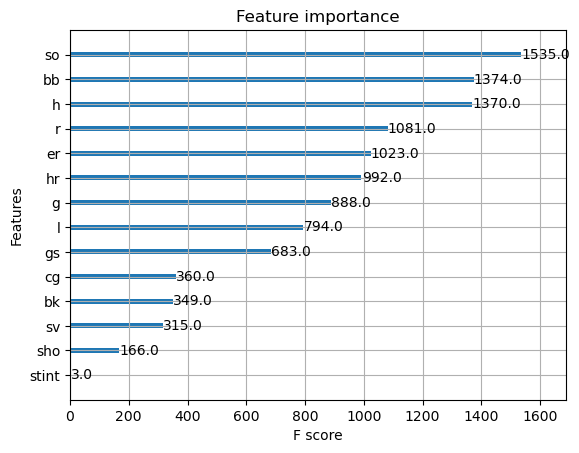

In [38]:
# 피처 중요도 시각화
plot_importance(xgboost)
plt.show()

# 가장 중요한 피처: strike-out